## PRACTICA OBLIGATORIA: **Redes Convolucionales**

* La práctica obligatoria de esta unidad consiste en un ejercicio de construcción de una red convolucional con Keras para la clasificación de imagenes de simpáticos perretes y gatetes. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo.
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import tensorflow as tf

from cv2 import imread

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.utils import shuffle

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/MyDrive/Bootcamp/Ejercicios/Sprint_16/Unidad_1/Challenge

/content/gdrive/MyDrive/Bootcamp/Ejercicios/Sprint_16/Unidad_1/Challenge


### Problema de Negocio y dataset

Una conocida empresa de información inmobiliaria utiliza un CAPTCHA visual de perros y gatos para detectar webscrappings intensivos y ataques de denegación de servicio. Últimamente, ha detectado que su sistema está empezando a flojear, es decir que hay muchos sistemas de detección automática de imágenes que son capaces de detectar que es un perro y un gato y salterse el CAPTCHA antirobots. Por eso nos ha pedido que entrenemos un modelo potente de clasificación que emule a estos sistemas con el objetivo de emplear como fotografías para el CAPTCHA aquellas que no sepa detectar este sistema emulador de chicos malos.  

Pues manos a la obra, tenemos que seleccionar en un conjunto de 1000 imágenes aquellas que peor se le daría clasificar a un potencial sistema anti-CAPTCHA.  

Para ello vamos a emplear un conjunto de train de 4000 imágenes de perretes y gatetes que se encuentran distribuidas en "data" en cuatro directorios "github_train_0",  "github_train_1", "githun_train_2" y "github_train_3". Los datos de las imagenes que tenemos que clasificar y luego seleccionar como las más "difíciles" están en "data" en el directorio "github_test".


### Se pide

1. Crear los datasets X,y de train y test, leyendo las imágenes de los directorios correspondientes (tendrás que leer todas las imágenes de los cuatro directorios para train) y a la vez que se leen adpatar su resolución para que todas tengan un tamaño de 32x32. En este caso puedes adaptar las funciones de los ejercicios de la unidad. NOTA: Ten en cuenta que la clase a la que pertenece en la foto está en el nombre del archivo.

2. Crea un modelo DL basado en redes convolucionales con al menos dos juegos Convolucional-Pooling. Sigue todo el proceso de ML (visualización del dataset, MiniEDA, Construcción del modelo)

3. Entrenar el modelo con un callback de Earlystopping con paciencia la que tengas :-). Muestra su historial de entrenamiento.

4. Evalua el modelo, haz un reporte de clasificacion y muestra la matriz de confianza.

5. Es el momento de seleccionar las imagenes: Selecciona el 10% de imágenes mal clasificadas de una y otra clase que tengan el mayor nivel de confianza de que pertenencían a la clase errónea. Es decir las imágenes de perros clasificadas como gatos y con la probabilidad de ser perror más alta.


### Extra (para hacer en clase)

Repite los pasos 3 a 5 utilizando el generador de imágenes sintéticas o Image Augmentation de Keras.



### **Función para leer train y test**

In [4]:
ROOT_PATH = './data/'
TRAIN_PATH_0 = ROOT_PATH + "github_train_0"
TRAIN_PATH_1 = ROOT_PATH + "github_train_1"
TRAIN_PATH_2 = ROOT_PATH + "github_train_2"
TRAIN_PATH_3 = ROOT_PATH + "github_train_3"
TEST_PATH = ROOT_PATH + "github_test"

In [5]:
def read_data(directorios, reshape_dim = (32,32)):
    X = []
    y = []
    for directorio in directorios:
        if os.path.isdir(directorio):
            for file in os.listdir(directorio):
                image = imread('/'.join([directorio, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)
                y.append(file.split(".")[0])

    return np.array(X),np.array(y)

In [6]:
X_train, y_train = read_data([TRAIN_PATH_0, TRAIN_PATH_1, TRAIN_PATH_2, TRAIN_PATH_3])

In [7]:
X_test, y_test = read_data([TEST_PATH])

In [8]:
y_train_series = pd.Series(y_train)

In [9]:
y_train_series.unique()

array(['cat', 'dog'], dtype=object)

In [10]:
y_train_labels = y_train.copy()
y_test_labels = y_test.copy()

In [11]:
y_train = (y_train == "cat").astype(int)
y_test = (y_test == "cat").astype(int)

### **Visualización de target y de imágenes**

In [12]:
y_train_series.value_counts()

,count
cat,2000
dog,2000


In [13]:
pd.Series(y_train).value_counts()

,count
1,2000
0,2000


El target está completamente equilibrado

In [14]:
class_names = ["dog", "cat"]
def show_images_batch(pets, n_cols, labels = [], names = class_names):
    n_rows = ((len(pets) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * 2, n_rows * 2.2))
    for index, cloth in enumerate(pets):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(cloth, cmap = "Greys")
        plt.axis("off")
        if len(labels):
            plt.title(names[labels[index]])

In [15]:
X_train, y_train = shuffle(X_train, y_train)

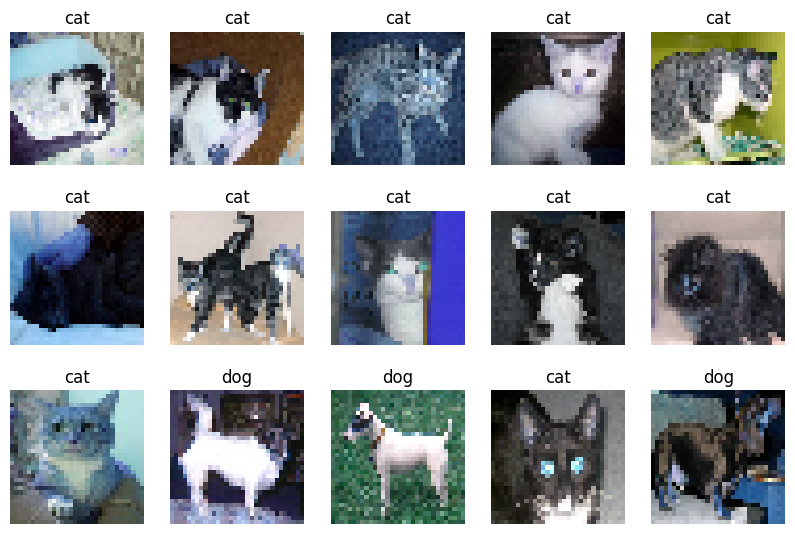

In [16]:
show_images_batch(X_train[:15], 5, y_train[:15])

Las imágenes se han cargado adecuadamente, aunque espero que el modelo las distinga mejor que yo, porque con esta definición en algunas no estoy muy seguro.

### **Construcción del modelo**

In [17]:
model = tf.keras.models.Sequential(
    [tf.keras.layers.Conv2D(filters = 30, kernel_size = (5,5), padding= "same",
                            activation = "relu", input_shape = X_train[0].shape),
     tf.keras.layers.MaxPooling2D(pool_size= (2,2)),

     tf.keras.layers.Conv2D(filters = 15, kernel_size = (3,3), padding = "same",
                            activation = "relu"),
     tf.keras.layers.MaxPooling2D(pool_size = (2,2)),

     tf.keras.layers.Flatten(),

     tf.keras.layers.Dense(400, activation="relu"),

     tf.keras.layers.Dropout(0.5),

     tf.keras.layers.Dense(200, activation= "relu"),
     tf.keras.layers.Dense(100, activation= "relu"),
     tf.keras.layers.Dense(1, activation = "sigmoid")]
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compilado

In [18]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9, nesterov = True)

model.compile(
    optimizer = optimizer,
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 30)     │         2,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 15)     │         4,065 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 15)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 400)            │       384,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        80,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491,146 (1.87 MB)

 Trainable params: 491,146 (1.87 MB)

 Non-trainable params: 0 (0.00 B)

### **Entrenamiento**

In [20]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("pets_model.keras")

history = model.fit(
    X_train,
    y_train,
    epochs = 100,
    batch_size = 32,
    validation_split = 0.2,
    callbacks = [early_stopping_cb, checkpoint_cb]
)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - accuracy: 0.5057 - loss: nan - val_accuracy: 0.4888 - val_loss: nan
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - accuracy: 0.4965 - loss: nan - val_accuracy: 0.4888 - val_loss: nan
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.4988 - loss: nan - val_accuracy: 0.4888 - val_loss: nan
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.5079 - loss: nan - val_accuracy: 0.4888 - val_loss: nan
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.5083 - loss: nan - val_accuracy: 0.4888 - val_loss: nan
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.4966 - loss: nan - val_accuracy: 0.4888 - val_loss: nan
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.5090 - loss: nan - val_accuracy: 0.4888 - val_loss: nan
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 0.5111 - loss: nan - val_accuracy: 0.4888 - val_loss: nan

Funciona muy mal, no mejora nada, voy a probar poniendo menos filtros en la primera capa y más en la segunda.

In [21]:
model_2 = tf.keras.models.Sequential(
    [tf.keras.layers.Conv2D(filters = 40, kernel_size = (5,5), padding= "same",
                            activation = "relu", input_shape = X_train[0].shape),
     tf.keras.layers.MaxPooling2D(pool_size= (2,2)),

     tf.keras.layers.Conv2D(filters = 20, kernel_size = (3,3), padding = "same",
                            activation = "relu"),
     tf.keras.layers.MaxPooling2D(pool_size = (2,2)),

     tf.keras.layers.Flatten(),

     tf.keras.layers.Dense(400, activation="relu"),

     tf.keras.layers.Dropout(0.5),

     tf.keras.layers.Dense(200, activation= "relu"),
     tf.keras.layers.Dense(100, activation= "relu"),
     tf.keras.layers.Dense(1, activation = "sigmoid")]
)


Compilado

In [22]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9, nesterov = True)

model_2.compile(
    optimizer = optimizer,
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

In [23]:
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 40)     │         3,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 20)     │         7,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 400)            │       512,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │        80,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 623,061 (2.38 MB)

 Trainable params: 623,061 (2.38 MB)

 Non-trainable params: 0 (0.00 B)

### **Entrenamiento**

In [24]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("pets_model.keras")

history = model_2.fit(
    X_train,
    y_train,
    epochs = 100,
    batch_size = 32,
    validation_split = 0.2,
    callbacks = [early_stopping_cb, checkpoint_cb]
)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.5028 - loss: nan - val_accuracy: 0.4888 - val_loss: nan
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.5013 - loss: nan - val_accuracy: 0.4888 - val_loss: nan
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.4911 - loss: nan - val_accuracy: 0.4888 - val_loss: nan
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.5041 - loss: nan - val_accuracy: 0.4888 - val_loss: nan
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - accuracy: 0.4918 - loss: nan - val_accuracy: 0.4888 - val_loss: nan
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.5142 - loss: nan - val_accuracy: 0.4888 - val_loss: nan
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.4936 - loss: nan - val_accuracy: 0.4888 - val_loss: nan
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - accuracy: 0.5113 - loss: nan - val_accuracy: 0.4888 - val_loss: nan
Epoc

Sigue funcionando muy mal, voy a probar a poner solo una capa densa oculta.

In [25]:
model_3 = tf.keras.models.Sequential(
    [tf.keras.layers.Conv2D(filters = 40, kernel_size = (5,5), padding= "same",
                            activation = "relu", input_shape = X_train[0].shape),
     tf.keras.layers.MaxPooling2D(pool_size= (2,2)),

     tf.keras.layers.Conv2D(filters = 20, kernel_size = (3,3), padding = "same",
                            activation = "relu"),
     tf.keras.layers.MaxPooling2D(pool_size = (2,2)),

     tf.keras.layers.Dropout(0.25),

     tf.keras.layers.Flatten(),

     tf.keras.layers.Dense(300, activation="relu"),

     tf.keras.layers.Dense(1, activation = "sigmoid")]
)


Compilado

In [26]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9, nesterov = True)

model_3.compile(
    optimizer = optimizer,
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

In [27]:
model_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 40)     │         3,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 20)     │         7,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 300)            │       384,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           301 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 394,861 (1.51 MB)

 Trainable params: 394,861 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

### **Entrenamiento**

In [28]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("pets_model.keras")

history = model_3.fit(
    X_train,
    y_train,
    epochs = 100,
    batch_size = 32,
    validation_split = 0.2,
    callbacks = [early_stopping_cb, checkpoint_cb]
)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.5048 - loss: 34818549177108135936.0000 - val_accuracy: 0.4888 - val_loss: 0.6935
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.5046 - loss: 0.6932 - val_accuracy: 0.5113 - val_loss: 0.6930
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.4964 - loss: 0.6934 - val_accuracy: 0.5113 - val_loss: 0.6931
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.5041 - loss: 0.6933 - val_accuracy: 0.4888 - val_loss: 0.6933
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.4894 - loss: 0.6934 - val_accuracy: 0.4888 - val_loss: 0.6934
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.4954 - loss: 0.6934 - val_accuracy: 0.4888 - val_loss: 0.6935
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.5107 - loss: 0.6931 - val_accuracy: 0.5113 - val_loss: 0.6931
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.499

Algo tengo que estar haciendo mal, voy a hacer una predicción porque creo que está clasificando todos en la misma clase

In [29]:
model_3.evaluate(X_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7632 - loss: 0.6869


[0.6932193636894226, 0.5]

In [30]:
predictions = model_3.predict(X_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [31]:
pd.DataFrame(predictions)[0].value_counts()

,count
0,
0.506005,1000


Efectivamente, algo tengo que estar haciendo mal porque siempre da la misma predicción.

In [32]:
model_4 = tf.keras.models.Sequential(
    [tf.keras.layers.Conv2D(filters = 40, kernel_size = (5,5), padding= "same",
                            activation = "relu", input_shape = X_train[0].shape),
     tf.keras.layers.MaxPooling2D(pool_size= (2,2)),

     tf.keras.layers.Conv2D(filters = 20, kernel_size = (3,3), padding = "same",
                            activation = "relu"),
     tf.keras.layers.MaxPooling2D(pool_size = (2,2)),

     tf.keras.layers.Flatten(),

     tf.keras.layers.Dense(400, activation="relu"),

     tf.keras.layers.Dropout(0.5),

     tf.keras.layers.Dense(200, activation= "relu"),
     tf.keras.layers.Dense(100, activation= "relu"),
     tf.keras.layers.Dense(2, activation = "softmax")]
)


Compilado

In [33]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9, nesterov = True)

model_4.compile(
    optimizer = optimizer,
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

In [34]:
model_4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 40)     │         3,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 20)     │         7,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 400)            │       512,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 200)            │        80,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 623,162 (2.38 MB)

 Trainable params: 623,162 (2.38 MB)

 Non-trainable params: 0 (0.00 B)

### **Entrenamiento**

In [35]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("pets_model.keras")

history = model_4.fit(
    X_train,
    y_train,
    epochs = 100,
    batch_size = 32,
    validation_split = 0.2,
    callbacks = [early_stopping_cb, checkpoint_cb]
)

Epoch 1/100


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(32,), output.shape=(32, 2)

Sigue funcionando muy mal, voy a probar a poner solo una capa densa oculta.

In [36]:
model_5 = tf.keras.models.Sequential(
    [tf.keras.layers.Conv2D(filters = 40, kernel_size = (5,5), padding= "same",
                            activation = "relu", input_shape = X_train[0].shape),
     tf.keras.layers.MaxPooling2D(pool_size= (2,2)),

     tf.keras.layers.Conv2D(filters = 20, kernel_size = (3,3), padding = "same",
                            activation = "relu"),
     tf.keras.layers.MaxPooling2D(pool_size = (2,2)),

     tf.keras.layers.Dropout(0.25),

     tf.keras.layers.Flatten(),

     tf.keras.layers.Dense(300, activation="relu"),

     tf.keras.layers.Dense(3, activation = "softmax")]
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compilado

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9, nesterov = True)

model_5.compile(
    optimizer = optimizer,
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

In [ ]:
model_5.summary()

### **Entrenamiento**

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("pets_model.keras")

history = model_5.fit(
    X_train,
    y_train,
    epochs = 100,
    batch_size = 32,
    validation_split = 0.2,
    callbacks = [early_stopping_cb, checkpoint_cb]
)

In [ ]:
from tensorflow import keras

In [ ]:
capas = [keras.layers.Conv2D(filters = 30, kernel_size = (3, 3),
                            input_shape = (X_train[0].shape),
                            padding = "same",
                            activation = 'relu'),
         keras.layers.MaxPooling2D(pool_size = (2, 2)),

# Añadimos otra capa de convolución y pooling
         keras.layers.Conv2D(filters = 15,
                             kernel_size = (3, 3),
                             padding = "same",
                             activation = 'relu'),
         keras.layers.MaxPooling2D(pool_size = (2, 2)),

# Añadimos una capa de flatten para convertir la salida de la capa de pooling en un vector
         keras.layers.Flatten(),

# Añadimos dos capas densas para la clasificación
         keras.layers.Dense(units = 150, activation = 'relu'),
         keras.layers.Dense(units = 100, activation = 'relu'),

# Añadimos la capa de salida con 6 neuronas, una por cada clase
         keras.layers.Dense(1, activation = 'sigmoid')]

# Creamos el modelo
model_6 = keras.Sequential(capas)

In [ ]:
model_6.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
model_6.summary()

In [ ]:
history = model_6.fit(X_train,
                    y_train,
                    validation_split = 0.2,
                    epochs = 100,
                    batch_size = 32, callbacks= [keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)])

In [ ]:
model_7 = tf.keras.Sequential(
    [tf.keras.layers.Conv2D(filters = 40, kernel_size = (3,3), padding= "same",
                            activation = "relu", input_shape = (X_train[0].shape)),
     tf.keras.layers.MaxPooling2D(pool_size= (2,2)),

     tf.keras.layers.Conv2D(filters = 20, kernel_size = (3,3), padding = "same",
                            activation = "relu"),
     tf.keras.layers.MaxPooling2D(pool_size = (2,2)),

     tf.keras.layers.Flatten(),

     tf.keras.layers.Dense(300, activation="relu"),

     tf.keras.layers.Dense(1, activation = "sigmoid")]
)


Compilado

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9, nesterov = True)

model_7.compile(
    optimizer = optimizer,
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

In [ ]:
model_7.summary()

### **Entrenamiento**

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("pets_model.keras")

history = model_7.fit(
    X_train,
    y_train,
    epochs = 100,
    batch_size = 32,
    validation_split = 0.2,
    callbacks = [early_stopping_cb, checkpoint_cb]
)

In [37]:
model_8 = tf.keras.Sequential()

model_8.add(tf.keras.layers.Conv2D(filters = 15, kernel_size= (3,3), padding= "same", activation= "relu", input_shape = (X_train[0].shape)))
model_8.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model_8.add(tf.keras.layers.Conv2D(filters = 30, kernel_size= (3,3), padding = "same", activation = "relu"))
model_8.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model_8.add(tf.keras.layers.Flatten())

model_8.add(tf.keras.layers.Dense(200, activation = "relu"))
model_8.add(tf.keras.layers.Dense(1, activation = "sigmoid"))

In [38]:
model_8.compile(optimizer = "adam", loss = "binary_crossentropy", metrics= ["accuracy"])

In [39]:
model_8.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 15)     │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 15)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 30)     │         4,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 200)            │       384,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 388,901 (1.48 MB)

 Trainable params: 388,901 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("pets_model.keras")

history = model_8.fit(X_train,
                      y_train,
                      validation_split = 0.2,
                      epochs = 100,
                      batch_size = 32,
                      callbacks = [early_stopping_cb, checkpoint_cb]
                      )

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.4926 - loss: 27.9602 - val_accuracy: 0.6087 - val_loss: 0.7007
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.5957 - loss: 0.6572 - val_accuracy: 0.6313 - val_loss: 0.6650
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.6979 - loss: 0.5595 - val_accuracy: 0.6237 - val_loss: 0.6769
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.7761 - loss: 0.4662 - val_accuracy: 0.6525 - val_loss: 0.6721
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8375 - loss: 0.3609 - val_accuracy: 0.6538 - val_loss: 0.6965
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.8902 - loss: 0.2852 - val_accuracy: 0.6338 - val_loss: 0.7600
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9250 - loss: 0.2112 - val_accuracy: 0.6612 - val_loss: 0.8541
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9526 - loss: 0.1518 -

### **Nuevo intento con más filtros**
Ahora que ya funciona el modelo voy a hacer algunas pruebas para mejorarlo

In [41]:
model_9 = tf.keras.Sequential()

model_9.add(tf.keras.layers.Conv2D(filters = 20, kernel_size= (3,3), padding= "same", activation= "relu", input_shape = (X_train[0].shape)))
model_9.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model_9.add(tf.keras.layers.Conv2D(filters = 40, kernel_size= (3,3), padding = "same", activation = "relu"))
model_9.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model_9.add(tf.keras.layers.Flatten())

model_9.add(tf.keras.layers.Dense(200, activation = "relu"))
model_9.add(tf.keras.layers.Dense(1, activation = "sigmoid"))

In [42]:
model_9.compile(optimizer = "adam", loss = "binary_crossentropy", metrics= ["accuracy"])

In [43]:
model_9.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 20)     │           560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 40)     │         7,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 8, 8, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 200)            │       512,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 520,201 (1.98 MB)

 Trainable params: 520,201 (1.98 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("pets_model.keras")

history = model_9.fit(X_train,
                      y_train,
                      validation_split = 0.2,
                      epochs = 100,
                      batch_size = 32,
                      callbacks = [early_stopping_cb, checkpoint_cb]
                      )

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.5330 - loss: 29.3433 - val_accuracy: 0.5863 - val_loss: 0.6662
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.6371 - loss: 0.6338 - val_accuracy: 0.6087 - val_loss: 0.6663
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.6878 - loss: 0.5750 - val_accuracy: 0.6325 - val_loss: 0.6756
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.7414 - loss: 0.5007 - val_accuracy: 0.6200 - val_loss: 0.7037
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.7828 - loss: 0.4518 - val_accuracy: 0.6288 - val_loss: 0.7139
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.8123 - loss: 0.3940 - val_accuracy: 0.6275 - val_loss: 0.7635
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8246 - loss: 0.3561 - val_accuracy: 0.6150 - val_loss: 0.7985
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8622 - loss: 0.2977 -

### **Dropout**
Sobreajusta mucho, voy a probar con un dropout

In [45]:
model_10 = tf.keras.Sequential()

model_10.add(tf.keras.layers.Conv2D(filters = 20, kernel_size= (3,3), padding= "same", activation= "relu", input_shape = (X_train[0].shape)))
model_10.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model_10.add(tf.keras.layers.Conv2D(filters = 40, kernel_size= (3,3), padding = "same", activation = "relu"))
model_10.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model_10.add(tf.keras.layers.Dropout(0.25))

model_10.add(tf.keras.layers.Flatten())

model_10.add(tf.keras.layers.Dense(200, activation = "relu"))
model_10.add(tf.keras.layers.Dense(1, activation = "sigmoid"))

In [46]:
model_10.compile(optimizer = "adam", loss = "binary_crossentropy", metrics= ["accuracy"])

In [47]:
model_10.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 20)     │           560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 40)     │         7,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 8, 8, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 200)            │       512,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 520,201 (1.98 MB)

 Trainable params: 520,201 (1.98 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("pets_model.keras")

history = model_10.fit(X_train,
                      y_train,
                      validation_split = 0.2,
                      epochs = 100,
                      batch_size = 32,
                      callbacks = [early_stopping_cb, checkpoint_cb]
                      )

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5036 - loss: 21.2374 - val_accuracy: 0.5950 - val_loss: 0.6842
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.6051 - loss: 0.6930 - val_accuracy: 0.5612 - val_loss: 0.6914
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.6754 - loss: 0.5925 - val_accuracy: 0.6275 - val_loss: 0.6614
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.7078 - loss: 0.5522 - val_accuracy: 0.6338 - val_loss: 0.6715
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.7620 - loss: 0.4880 - val_accuracy: 0.6325 - val_loss: 0.6670
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.7988 - loss: 0.4177 - val_accuracy: 0.6350 - val_loss: 0.6924
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.8068 - loss: 0.3957 - val_accuracy: 0.6700 - val_loss: 0.6614
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8307 - loss: 0.3511 -

### **Otro Dropout**
sigue sobreajustando así que le voy a meter otra capa de dropout

In [49]:
model_11 = tf.keras.Sequential()

model_11.add(tf.keras.layers.Conv2D(filters = 20, kernel_size= (3,3), padding= "same", activation= "relu", input_shape = (X_train[0].shape)))
model_11.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model_11.add(tf.keras.layers.Conv2D(filters = 40, kernel_size= (3,3), padding = "same", activation = "relu"))
model_11.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model_11.add(tf.keras.layers.Dropout(0.25))

model_11.add(tf.keras.layers.Flatten())

model_11.add(tf.keras.layers.Dense(200, activation = "relu"))

model_11.add(tf.keras.layers.Dropout(0.5))

model_11.add(tf.keras.layers.Dense(1, activation = "sigmoid"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [50]:
model_11.compile(optimizer = "adam", loss = "binary_crossentropy", metrics= ["accuracy"])

In [51]:
model_11.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 20)     │           560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 16, 16, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 16, 40)     │         7,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 8, 8, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 8, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 200)            │       512,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 520,201 (1.98 MB)

 Trainable params: 520,201 (1.98 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("pets_model.keras")

history_11 = model_11.fit(X_train,
                      y_train,
                      validation_split = 0.2,
                      epochs = 100,
                      batch_size = 32,
                      callbacks = [early_stopping_cb, checkpoint_cb]
                      )

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.5049 - loss: 22.2495 - val_accuracy: 0.5713 - val_loss: 0.6793
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.5952 - loss: 0.6731 - val_accuracy: 0.5788 - val_loss: 0.6701
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.6177 - loss: 0.6373 - val_accuracy: 0.5775 - val_loss: 0.6654
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.6451 - loss: 0.6106 - val_accuracy: 0.5713 - val_loss: 0.6939
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.6573 - loss: 0.5924 - val_accuracy: 0.5913 - val_loss: 0.6784
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.6827 - loss: 0.5796 - val_accuracy: 0.5987 - val_loss: 0.6718
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.6912 - loss: 0.5527 - val_accuracy: 0.5975 - val_loss: 0.6856
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.7120 - loss: 0.5150 -

Sigue sobreajustando, pero voy a terminar el ejercicio con lo que tengo. El que mejor iba era el 10 (un solo dropout) antes de empezar a sobreajustar, así que me quedo con él. He vuelto a instanciarlo para obtener el history original, no el que obtendría al reanudar el entrenamiento y seguir sobreajustando.

<Axes: >

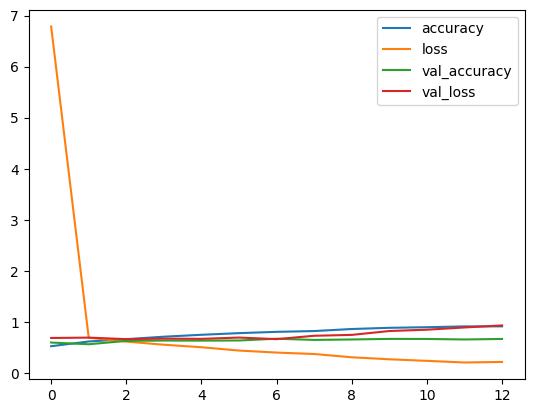

In [53]:
pd.DataFrame(history.history).plot()

Al principio la función de pérdida de train es muy alta, baja drásticamente y sigue bajando, la función de pérdida de validación baja un poco al principio, pero después, a medida que sobreajusta va subiendo. Debido al sobreajuste el accuracy de train a subiendo, pero el de validation se mantiene constante.

### **Evaluación**

In [63]:
model_10.evaluate(X_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5520 - loss: 0.7099


[0.6677037477493286, 0.5989999771118164]

Tiene un accuracy cercano al 50% es poco mejor que un clasificador aleatorio, necesitaríamos más datos y trabajar más en él para mejorarlo, son muy pocos datos para un modelo de deep learning. Sin embargo, para saber cuáles son las imágenes que peor predice puede ser suficiente.

In [58]:
probabilities = model_10.predict(X_test)
y_pred = np.array([(pred >= 0.5).astype(int) for pred in probabilities]).T[0]

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [59]:
y_pred.shape

(1000,)

In [60]:
y_pred[:5]

array([0, 0, 0, 0, 1])

In [61]:
y_test[:5]

array([1, 1, 1, 1, 1])

In [62]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.68      0.63       500
           1       0.62      0.52      0.56       500

    accuracy                           0.60      1000
   macro avg       0.60      0.60      0.60      1000
weighted avg       0.60      0.60      0.60      1000



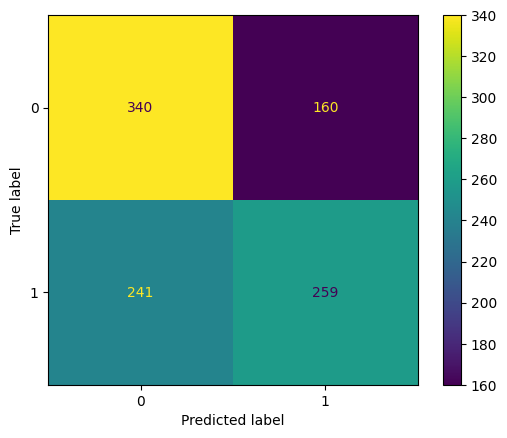

In [64]:
c_matrix = ConfusionMatrixDisplay(confusion_matrix= "cm")
c_matrix.from_predictions(y_test, y_pred)

Vemos que no es un clasificador muy bueno y se le escapan bastantes imágenes.

### **10% de imágenes que peor predice**

In [67]:
probabilities[:10]

array([[0.40519762],
       [0.20729533],
       [0.45015028],
       [0.30757186],
       [0.73556006],
       [0.50460005],
       [0.18213312],
       [0.65657306],
       [0.50432855],
       [0.5219053 ]], dtype=float32)

In [70]:
probabilities = probabilities.T[0]

In [71]:
df_prob = pd.DataFrame({"true": y_test, "prediction": y_pred, "prob": probabilities})

In [72]:
cond_1 = df_prob["true"] != df_prob["prediction"]

In [85]:
df_gatos = df_prob.loc[cond_1].sort_values("prob", ascending = True).iloc[: int(round(len(df_prob.loc[cond_1])*0.1, 0))]
df_gatos

,true,prediction,prob
717,1,0,0.080117
938,1,0,0.087852
939,1,0,0.115755
666,1,0,0.123712
20,1,0,0.130705
123,1,0,0.135458
50,1,0,0.138013
710,1,0,0.140686
782,1,0,0.147180
770,1,0,0.156925


In [84]:
df_perros = df_prob.loc[cond_1].sort_values("prob", ascending = False).iloc[: int(round(len(df_prob.loc[cond_1])*0.1, 0))]
df_perros

,true,prediction,prob
511,0,1,0.932780
374,0,1,0.884626
739,0,1,0.874695
958,0,1,0.866370
651,0,1,0.864649
426,0,1,0.849133
741,0,1,0.844996
433,0,1,0.840423
659,0,1,0.834050
987,0,1,0.821324


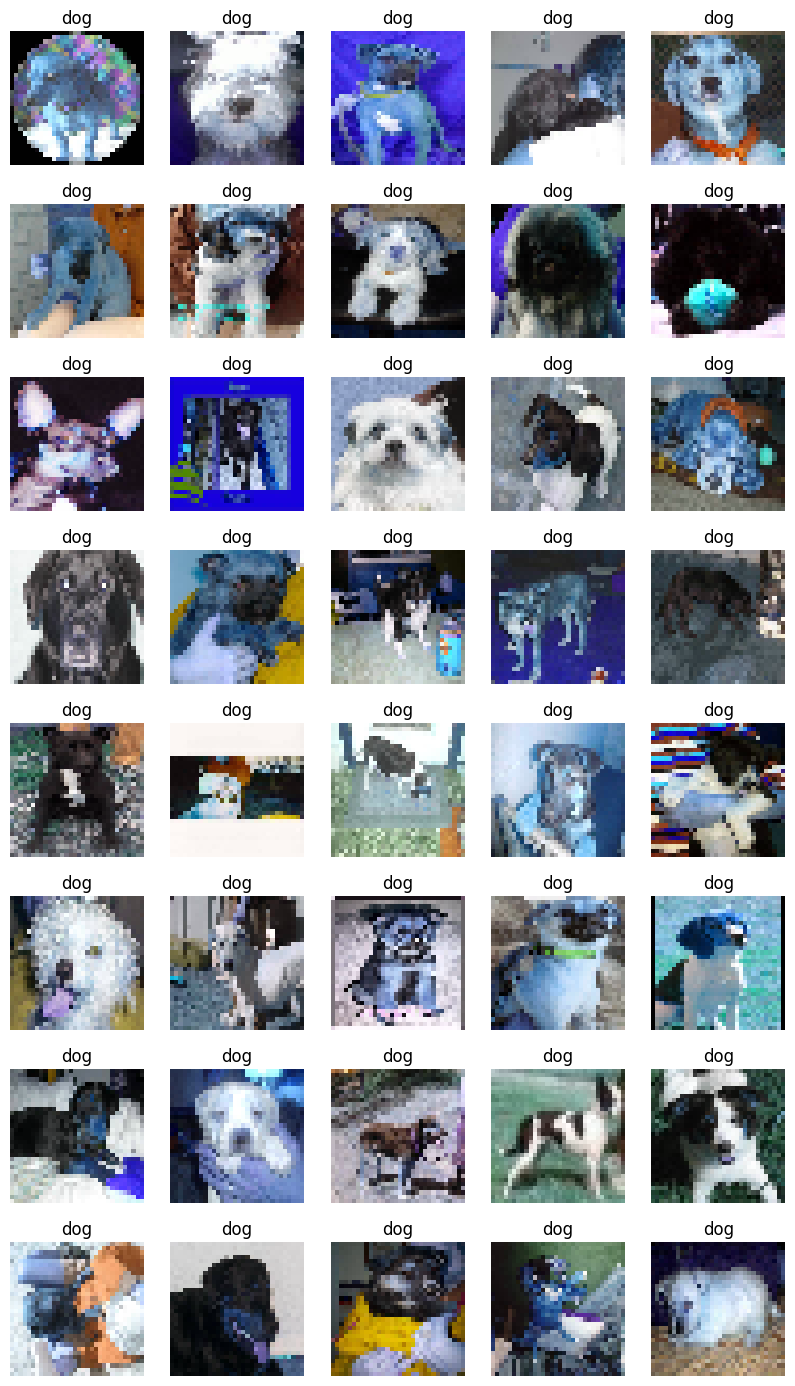

In [86]:
show_images_batch(X_test[df_perros.index.tolist()], 5, y_test[df_perros.index.tolist()])

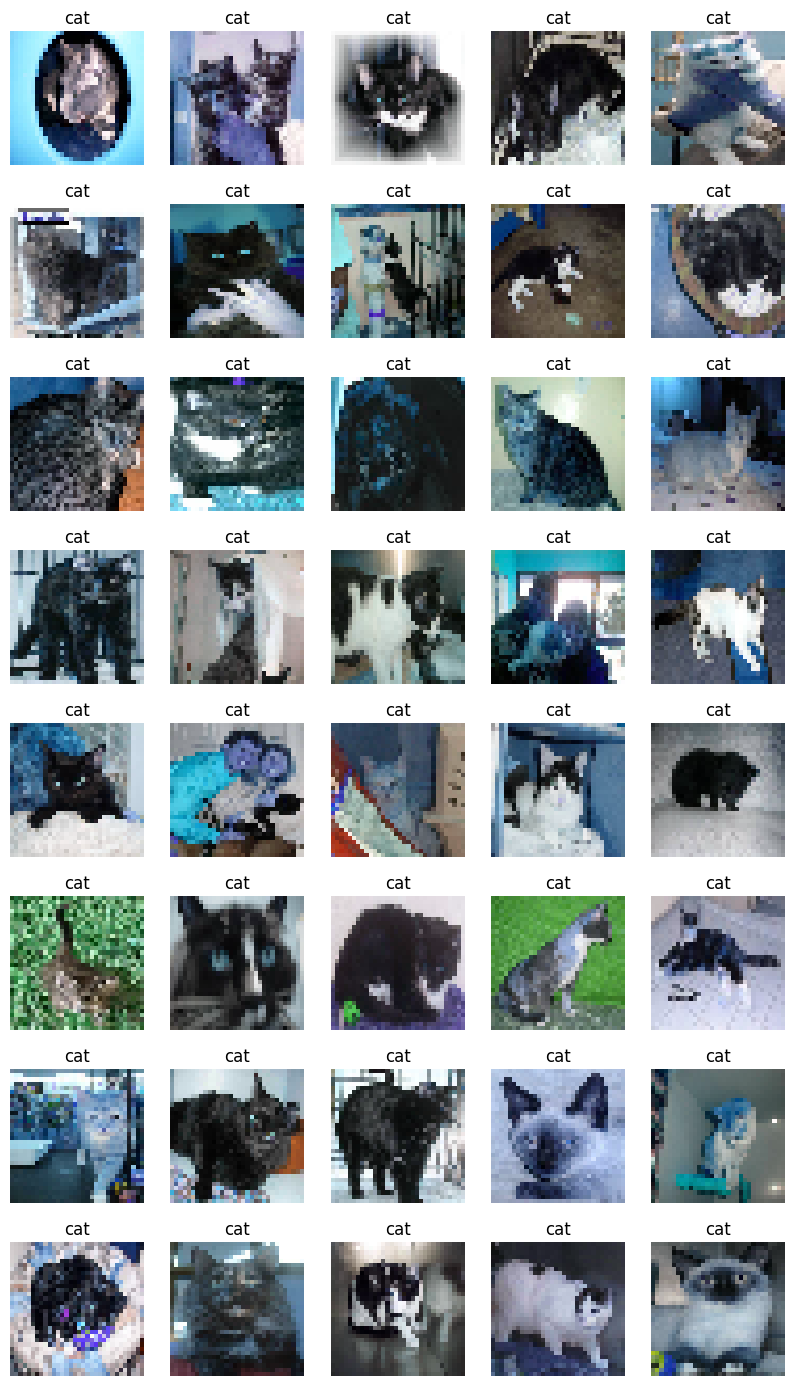

In [87]:
show_images_batch(X_test[df_gatos.index.tolist()], 5, y_test[df_gatos.index.tolist()])